In [1]:
#| default_exp diffgeo

In [2]:
#| export

from blender_tissue_cartography import mesh as tcmesh
from blender_tissue_cartography import interpolation as tcinterp
from blender_tissue_cartography import rotation as tcrot

import numpy as np
from copy import deepcopy
import warnings
import igl

from scipy import sparse, linalg

In [3]:
import os
import matplotlib.pyplot as plt
from importlib import reload

In [4]:
np.set_printoptions(suppress=True)

## Tools for analysis in 3d

When analysing data in cartographic projections, we have to make sure we are always accounting for mapping distortion and curvature. This notebook builds the relevant tools, including for vector calculus on curved surfaces.

When analyzing quantities computed in the UV cartographic projection (e.g. cell areas, orientation, tissue flow speed obtained from optical flow), you need to account for the cartographic projection. I generally recommend doing this by _mapping every object back to 3d as soon as possible_. This will mininize the number of possible errors. Example: you want to evaluate the angle between two edges of a cell.
1. You could do so in the UV map using the induced metric (see below). This is error prone: did you calculate the metric correctly? Did you use the metric or its inverse?
2. You could map back the location of the cell vertices to 3d, and then calculate the edge vectors in 3d. This minimizes possibilities for confusion.

### Mapping distortion

A map between two meshes is defined on a per-triangle basis (i.e. which triangle of the "source" mesh gets mapped to which one of the "target" mesh). The map between a 3d mesh and its UV unwrapping is a special case of this.

The mapping distortion is described by the _Jacobian_, defined per triangle. For more detail, see [here](https://www.cs.cmu.edu/~kmcrane/Projects/Other/OverviewConformalGeometryProcessing.pdf). The simplest kind of mapping distortion is _area distortion_, which is simply the ratio of (target triangle area) / (source triangle area).

In general, many mapping related quantities, like area distortion, are most easily computed per triangle. We can "move" them to mesh vertices by interpolation. If we keep all of our quantities of interest defined per vertex, it will simplify book-keeping.

The tools in this notebook only work for triangular meshes! Only for triangular meshes is the per-face map distortion uniquely defined.

In [5]:
#| export

def compute_per_vertex_area_distortion(source_vertices, source_faces, target_vertices, target_faces,
                                       evaluate_at='source', cutoff=1e-15):
    """
    Compute area distortion factor for map between meshes.
    
    The result is evaluated at the vertices of the source or target mesh.
    Faces must be such that faces[i] is mapped to target_faces[i].
    This function computes (target area / source area).
    
    This can be used to (a) visualize map distortion and (b)
    correct for it, for example by using it as a weighting factor
    for averages.
    
    Example (compute distortion of UV map):
    compute_per_vertex_area_distortion(mesh.texture_vertices, mesh.texture_tris,
                                       mesh.vertices, mesh.tris)
    
    Parameters
    ----------
    source_vertices : np.array
        Source mesh vertices.
    source_faces : np.array of shape (..., 3)
        Spurce mesh faces. Must be triangular.
    target_vertices : np.array
        Target mesh vertices.
    target_faces : np.array of shape (..., 3)
        Target mesh faces. Must be triangular.
    evaluate_at : str, 'source' or 'target'
        Whether to evaluate the result at the source or target
        mesh vertices.
    cutoff : float
        Numerical cutoff for small target areas (avoid 0 division error)
    Returns
    -------
    area_ratio_at_vertices : np.array
        Area distortion factor (source area / target area) evaluated on source or target mesh vertices.
    """
    areas_source = igl.doublearea(source_vertices, source_faces)
    areas_target = igl.doublearea(target_vertices, target_faces)
    mask_source = np.abs(areas_source) < cutoff
    areas_source[mask_source] = cutoff * np.sign(areas_source[mask_source])
    area_ratio = areas_target/areas_source
    if evaluate_at == 'target':
        area_ratio_at_vertices = igl.average_onto_vertices(target_vertices, target_faces,
                                                           np.stack(target_vertices.shape[1]*[area_ratio]).T)[:,0]
    elif evaluate_at == 'source':
        area_ratio_at_vertices = igl.average_onto_vertices(source_vertices, source_faces,
                                                           np.stack(source_vertices.shape[1]*[area_ratio]).T)[:,0]
    return area_ratio_at_vertices

In [6]:
#| export

def get_area_distortion_in_UV(mesh, uv_grid_steps=1024, map_back=True):
    """
    Get area distortion of UV map, interpolated across the UV square.
    
    Used to measure area distortion of your cartographic mapping.
    This can be used to (a) visualize map distortion and (b)
    correct for it, for example by using it as a weighting factor
    for averages.
    
    Assumes the map $x,y,z \mapsto u,v$ to be invertible. This is not guaranteed
    - you can create overlapping UV coordinates in blender. The provided UV coordinates
    will be mapped back to [0, 1]^2 if map_back is True. Else, coordinates  outside [0,1] are ignored.
    
    Parameters
    ----------
    mesh : tcmesh.ObjMesh
        Input mesh with UV coordinates.
    uv_grid_steps : int, default 256
        Size of UV grid. Determines resolution of result.
    map_back : bool, default True
        Map back the UV coordinates to [0,1]^2. Else, coordinates outside [0,1] are ignored.

    Returns
    -------
    distortion_interpolated : np.array of shape (uv_grid_steps, uv_grid_steps)
        Area distortion across [0,1]^2 UV grid, with uniform step size. UV positions that don't
        correspond to any value are set to np.nan.

    """
    distortion = compute_per_vertex_area_distortion(mesh.texture_vertices, mesh.texture_tris,
                                                    mesh.vertices, mesh.tris, evaluate_at='source')
    distortion_interpolated = tcinterp.interpolate_per_vertex_field_to_UV(mesh, distortion,
                                                                          uv_grid_steps=uv_grid_steps,
                                                                          map_back=map_back,
                                                                          domain='per-texture-vertex')
    return distortion_interpolated

In [7]:
mesh = tcmesh.ObjMesh.read_obj("movie_example/initial_uv.obj")

In [8]:
distortion = compute_per_vertex_area_distortion(mesh.texture_vertices, mesh.texture_tris,
                                                mesh.vertices, mesh.tris)


(-0.04055375, 1.04151075, 0.19788145000000001, 0.8123095499999999)

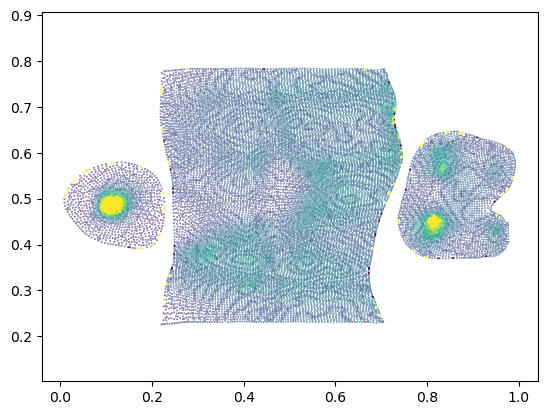

In [9]:
plt.scatter(*mesh.texture_vertices.T, c=distortion, vmin=0, vmax=1e7, s=0.1)
plt.axis("equal")

In [10]:
distortion_interpolated = get_area_distortion_in_UV(mesh)

/home/nikolas/Documents/UCSB/streichan/numerics/code/python code/jupyter notebooks/blender-tissue-cartography/blender_tissue_cartography/interpolation.py:221: RuntimeWarning: UV map has self-intersections, 33 flipped triangles.
  warnings.warn("UV map has self-intersections, {} flipped triangles.".format(flipped_triangles),


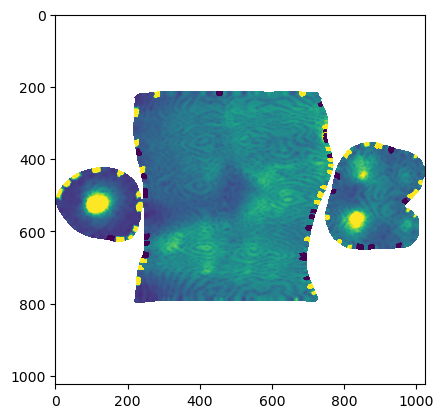

In [11]:
plt.imshow(distortion_interpolated, vmin=0, vmax=0.75*1e7)

In [12]:
# aliasing when interpolating ... how to fix that?

In [13]:
#| export

def compute_per_vertex_angle_distortion(source_vertices, source_faces, target_vertices, target_faces,
                                        evaluate_at='source', cutoff=1e-15):
    """  
    Compute angle distortion for map between meshes.
    
    The result is evaluated at the vertices of the source or target mesh.
    Faces must be such that faces[i] is mapped to target_faces[i].
    This function computes np.abs(target angles - source angles),
    averaged over each triangle (in radians).
    
    This can be used to visualize map distortion.
    
    Example (compute distortion of UV map):
    compute_per_vertex_angle_distortion(mesh.texture_vertices, mesh.texture_tris,
                                        mesh.vertices, mesh.tris)
    
    Parameters
    ----------
    source_vertices : np.array
        Source mesh vertices.
    source_faces : np.array of shape (..., 3)
        Spurce mesh faces. Must be triangular.
    target_vertices : np.array
        Target mesh vertices.
    target_faces : np.array of shape (..., 3)
        Target mesh faces. Must be triangular.
    evaluate_at : str, 'source' or 'target'
        Whether to evaluate the result at the source or target
        mesh vertices.
    Returns
    -------
    area_ratio_at_vertices : np.array
        Area distortion factor (source area / target area) evaluated on source or target mesh vertices.
    """
    source_angles = igl.internal_angles(source_vertices, source_faces)
    target_angles = igl.internal_angles(target_vertices, target_faces)
    angle_error = np.abs(source_angles-target_angles).mean(axis=-1)
    if evaluate_at == 'target':
        angle_error_at_vertices = igl.average_onto_vertices(target_vertices, target_faces,
                                                            np.stack(target_vertices.shape[1]*[angle_error]).T)[:,0]
    elif evaluate_at == 'source':
        angle_error_at_vertices = igl.average_onto_vertices(source_vertices, source_faces,
                                                            np.stack(source_vertices.shape[1]*[angle_error]).T)[:,0]
    return angle_error_at_vertices

In [14]:
compute_per_vertex_angle_distortion(mesh.texture_vertices, mesh.texture_tris,
                                    mesh.vertices, mesh.tris).mean() 


0.19397542576446897

### Jacobian

In general, in addition to getting inflated or shrunk, during the mapping process, a triangle is also rotated and sheared. The full transformation properties are encoded by the Jacobian matrix.

You need the Jacobian for example to map vectors (e.g. displacement from optical flow) that you calculated in UV space back into 3d.

Using the `tcinterp.interpolate_per_vertex_field_to_UV`, you can interpolate the Jacobian from mesh vertices into the whole UV square.

In [15]:
source_vertices, source_faces = (mesh.texture_vertices, mesh.texture_tris)
target_vertices, target_faces = (mesh.vertices, mesh.tris)

In [16]:
A = source_vertices[source_faces]
B = target_vertices[target_faces]

A = (A.transpose((1,0,2)) - A.mean(axis=1)).transpose((1,0,2))
B = (B.transpose((1,0,2)) - B.mean(axis=1)).transpose((1,0,2))

In [17]:
A.shape, B.shape

((40420, 3, 2), (40420, 3, 3))

In [18]:
jac = np.stack([np.linalg.lstsq(a, b, rcond=None)[0].T for a,b in zip(A, B)]) # vectorize?
jac.shape

(40420, 3, 2)

In [19]:
i = 100

np.linalg.norm(A[i] @ jac[i].T - B[i], axis=-1) / np.linalg.norm(B[i], axis=-1)

array([0., 0., 0.])

In [20]:
jac_per_vertices = np.stack([igl.average_onto_vertices(source_vertices, source_faces, x)
                             for x in jac.transpose((1,0,2))], axis=1)

In [21]:
jac_per_vertices.shape, source_vertices.shape

((20623, 3, 2), (20623, 2))

In [22]:
#| export

def compute_per_face_jacobian(source_vertices, source_faces, target_vertices, target_faces):
    """
    Compute Jacobian factor for map between meshes.
    
    Faces must be such that faces[i] is mapped to target_faces[i].
    This function computes the Jacobian mapping tangent vectors of the 
    source mesh to tangent vectors of the target mesh.
    The result is evaluated at the mesh faces.

    Example (compute distortion of UV map):
    compute_per_vertex_jacobian(mesh.texture_vertices, mesh.texture_tris
                                mesh.vertices, mesh.tris)
    
    Parameters
    ----------
    source_vertices : np.array
        Source mesh vertices.
    source_faces : np.array of shape (..., 3)
        Spurce mesh faces. Must be triangular.
    target_vertices : np.array
        Target mesh vertices.
    target_faces : np.array of shape (..., 3)
        Target mesh faces. Must be triangular.
    Returns
    -------
    Jacobian : np.array
        Jacobian. Shape is (n_faces, d_target, d_source),
        where d is the spatial dimension (e.g. 2, 3).
    """
    A = source_vertices[source_faces]
    B = target_vertices[target_faces]
    A = (A.transpose((1,0,2)) - A.mean(axis=1)).transpose((1,0,2))
    B = (B.transpose((1,0,2)) - B.mean(axis=1)).transpose((1,0,2))
    jac = np.stack([np.linalg.lstsq(a, b, rcond=None)[0].T for a,b in zip(A, B)])
    return jac

def compute_per_vertex_jacobian(source_vertices, source_faces, target_vertices, target_faces,
                                evaluate_at='source'):
    """
    Compute Jacobian factor for map between meshes.
    
    Faces must be such that faces[i] is mapped to target_faces[i].
    This function computes the Jacobian mapping tangent vectors of the 
    source mesh to tangent vectors of the target mesh.
    The result is evaluated at the vertices of the source mesh.
    
    Important: after you apply the per-vertex Jacobian,
    you may still need to permute the result, defined per
    source vertex, so it is defined per target mesh,
    e.g. using mesh.get_vertex_to_texture_vertex_indices()
    if mapping from 3d to UV.
    
    Example (compute distortion of UV map):
    compute_per_vertex_jacobian(mesh.texture_vertices, mesh.texture_tris
                                mesh.vertices, mesh.tris)
    
    Parameters
    ----------
    source_vertices : np.array
        Source mesh vertices.
    source_faces : np.array of shape (..., 3)
        Spurce mesh faces. Must be triangular.
    target_vertices : np.array
        Target mesh vertices.
    target_faces : np.array of shape (..., 3)
        Target mesh faces. Must be triangular.
    evaluate_at : str, 'source' or 'target'
        Whether to evaluate the result at the source or target
        mesh vertices.
        
    Returns
    -------
    Jacobian : np.array
        Jacobian. Shape is (n_vertices, d_target, d_source),
        where d is the spatial dimension (e.g. 2, 3).
    """
    jac_per_face = compute_per_face_jacobian(source_vertices, source_faces,
                                             target_vertices, target_faces)
    jac_per_vertices = np.stack([igl.average_onto_vertices(source_vertices, source_faces, x)
                                 for x in jac_per_face.transpose((1,0,2))], axis=1)        
    return jac_per_vertices

In [23]:
jac = compute_per_vertex_jacobian(mesh.texture_vertices, mesh.texture_tris, mesh.vertices, mesh.tris)
jac.shape

(20623, 3, 2)

In [24]:
area_distortion = compute_per_vertex_area_distortion(mesh.texture_vertices, mesh.texture_tris,
                                                     mesh.vertices, mesh.tris)


In [25]:
np.sqrt(np.linalg.det(np.einsum('vij,vik->vjk', jac, jac)))

array([4.60653700e+07, 5.09661585e+07, 4.11232282e+07, ...,
       1.73749635e+09, 3.20935393e+09, 5.04391082e+09])

In [26]:
# the product of the Jacobian singular values will give you the area distortion

np.prod(np.linalg.svd(jac).S, axis=1) / np.abs(area_distortion)

array([0.99769177, 0.99467172, 0.99815593, ..., 1.        , 0.99925048,
       1.        ])

In [27]:
jac_interpolated = tcinterp.interpolate_per_vertex_field_to_UV(mesh, jac, uv_grid_steps=256,
                                                               map_back=True, domain='per-texture-vertex')

In [28]:
jac_interpolated.shape

(256, 256, 3, 2)

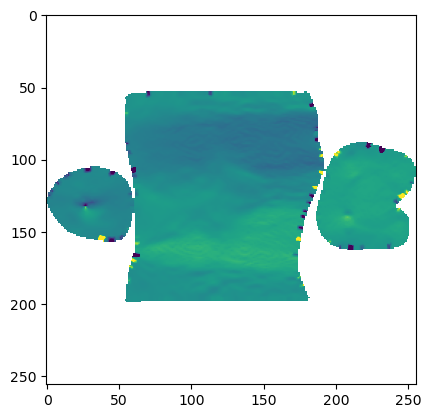

In [29]:
plt.imshow(jac_interpolated[..., 0,1], vmin=-1e4, vmax=1e4)

### Induced metric tensor

The induced metric is defined via $g = J^T \cdot J$ where $J$ is the Jacobian of the map from UV-space to 3d space.

Note: when doing calculations like shown below, `np.einsum` is invaluable.

In [30]:
#| export

def get_metric_norm(vf, g):
    """Compute norm of vectorfield vf (shape (..., d)) using metric g."""
    return np.sqrt(np.einsum('...i,...ij,...j->...', vf, g, vf))

def get_metric_angle(vf1, vf2, g):
    """Compute angle in radians between two vector fields (shape (..., d)) in degrees using metric g."""
    norm1 = get_metric_norm(vf1, g)
    norm2 = get_metric_norm(vf2, g)
    inner = np.einsum('...i,...ij,...j->...', vf1, g, vf2)
    angle = np.arccos((1-1e-5)*inner/(norm1*norm2))
    return angle

def get_induced_metric(mesh):
    """
    Compute induced metric, evaluated at textures vertices.
    
    See https://en.wikipedia.org/wiki/Induced_metric.
    
    Parameters
    ----------
    mesh : tcmesh.ObjMesh
        Mesh. Must have texture map defined
        
    Returns
    -------
    g : np.array of shape (n_texture_vertices, 2, 2)
        Induced metric.
        
    """
    jac = compute_per_vertex_jacobian(mesh.texture_vertices, mesh.texture_tris, mesh.vertices, mesh.tris)
    g = np.einsum('via,vib->vab', jac, jac)
    return g

In [31]:
# this is how you calculate the induced metric

jac = compute_per_vertex_jacobian(mesh.texture_vertices, mesh.texture_tris, mesh.vertices, mesh.tris)
g = np.einsum('via,vib->vab', jac, jac)

In [32]:
# the determinant of the metric gives the local area distortion
    
np.sqrt(np.linalg.det(g)) / np.abs(area_distortion)

array([0.99769177, 0.99467172, 0.99815593, ..., 1.        , 0.99925048,
       1.        ])

In [33]:
# using the metric, and np.einsum, you can calculate norms and angles of vectors

vf = np.random.normal(size=jac[:,0].shape, scale=0.1)

np.sqrt(np.einsum('...i,...ij,...j->...', vf, g, vf))

array([  908.87760374,  1642.69176941,   444.55463193, ...,
       51307.46554109, 17312.81116519,  4326.10043223])

In [34]:
mapped_to_3d = np.einsum('vij,vj->vi', jac, vf)
np.linalg.norm(mapped_to_3d, axis=-1)

array([  908.87760374,  1642.69176941,   444.55463193, ...,
       51307.46554109, 17312.81116519,  4326.10043223])

In [35]:
jac.shape

(20623, 3, 2)

## Vector calculus on curved surfaces

How to generalize the familiar operations of vector calculus (div, rot, grad, etc) to curved surfaces is a key part of differential geometry. There are different approaches for doing surface differential geometry numerically:

1. Using local coordinates/parametrizations (i.e. the way physicists learn it in GR). This is prone to errors and numerically unfavorable
2. Using "intrinsic" discretization schemes like [Discrete Exterior Calculus](https://www.cs.cmu.edu/~kmcrane/Projects/DDG/paper.pdf). These are elegant, numerically efficient, but difficult to use and understand for non-experts.

Here, we take a less elegant, but simpler approach that takes advantage of the fact that our surfaces are embedded in 3d cartesian space. All vector and tensor field are mapped back into 3d, so that their components are defined in $x,y,z$ coordinates. Then we can imagine "extending" from the surface into full 3d space by defining them to be constant along the local surface normal. Then we are back to normal vector calculus!

In practice, we don't need to do this extension explicitly. We can compute the derivative of any quantity defined on mesh vertices in such a way that the derivative along the normal direction is 0. This is implemented by standard "finite-element" gradient operators. See here: https://libigl.github.io/libigl-python-bindings/tut-chapter1/#gradient

To do: check this is mathematically fine

In [36]:
#| export

def tri_grad(field, vertices, faces, grad_matrix=None):
    """
    Calculate gradient of function defined on vertices of triangular mesh.

    If a vector or tensor field is passed, the gradient is applied
    to each component individually.
    
    See https://libigl.github.io/libigl-python-bindings/tut-chapter1/#gradient

    Parameters
    ----------
    field : np.array of shape (#vertices,...)
        scalar, vector, or tensor field defined at mesh vertices
    vertices : np.array of shape (#vertices, dim)
        vertices.
    faces : np.array of shape (#faces, 3)
        Triangular faces.
    grad_matrix : scipy.sparse, optional
        Gradient operator. The default is None (calculate from vertices, faces).

    Returns
    -------
    np.array of shape (#vertices, dim, ...)
        Gradient of scalar function/tensor, defined on vertices.
        Axis 1 comprises the gradients along x,y,z.

    """
    if grad_matrix is None:  # calculate gradient operator
        grad_matrix = igl.grad(vertices, faces)
    # calculate the gradient of field by matrix multiplication
    index_shape = field.shape[1:]
    field = field.reshape((field.shape[0], int(np.prod(field.shape[1:]))))
    grad_field = grad_matrix.dot(field)
    # order='F' copied from igl tutorial
    grad_field = grad_field.reshape((faces.shape[0], vertices.shape[1], field.shape[1]), order='F')
    # now, average onto vertices. Need to iterate over all other axes
    grad_field = np.stack([igl.average_onto_vertices(vertices, faces, grad_field[:, :, i])
                           for i in range(grad_field.shape[2])], axis=2)
    # finally, reshape into original shape
    grad_field = grad_field.reshape(grad_field.shape[:2] + index_shape)
    return grad_field

In [37]:
mesh = tcmesh.ObjMesh.read_obj("movie_example/initial_uv.obj")

In [38]:
# get some random fields - eigenfunctions of the laplacian

laplacian = igl.cotmatrix(mesh.vertices, mesh.tris)
mass = igl.massmatrix(mesh.vertices, mesh.tris)

eigen_vals, eigen_vecs = sparse.linalg.eigsh(-laplacian, M=mass, k=10, ncv=100, which="SM")
eigen_vals, eigen_vecs = (eigen_vals[1:], eigen_vecs[:, 1:])

eigen_vals = eigen_vals / eigen_vals[0]
eigen_vecs = eigen_vecs / np.abs(eigen_vecs).mean()

scalar_field = eigen_vecs[:,0]
vector_field = eigen_vecs[:,:3]
tensor_field = eigen_vecs.reshape((-1, 3, 3))

In [39]:
vertices, faces = (mesh.vertices, mesh.tris)
field = tensor_field

In [40]:
tri_grad(tensor_field, mesh.vertices, mesh.tris, ).shape

(20212, 3, 3, 3)

In [41]:
scalar_gradient = tri_grad(scalar_field, mesh.vertices, mesh.tris,)
normals = igl.per_vertex_normals(mesh.vertices, mesh.tris)
normals = (normals.T/np.linalg.norm(normals, axis=-1)).T

In [42]:
normal_component = (np.abs(np.einsum('vi,vi->v', normals, scalar_gradient))
                    / np.linalg.norm(scalar_gradient, axis=-1))

In [43]:
np.mean(normal_component) 

0.0011230080906231403

In [45]:
# here is how you would map the gradients into 2d. You first need to apply the Jacobian,
# and then you still need to reindex.

jac = compute_per_vertex_jacobian(mesh.vertices, mesh.tris, mesh.texture_vertices, mesh.texture_tris, )
scalar_gradient_projected = np.einsum('vij,vj->vi', jac,
                                      scalar_gradient)[mesh.get_vertex_to_texture_vertex_indices()]

(-0.04055375, 1.04151075, 0.19788145000000001, 0.8123095499999999)

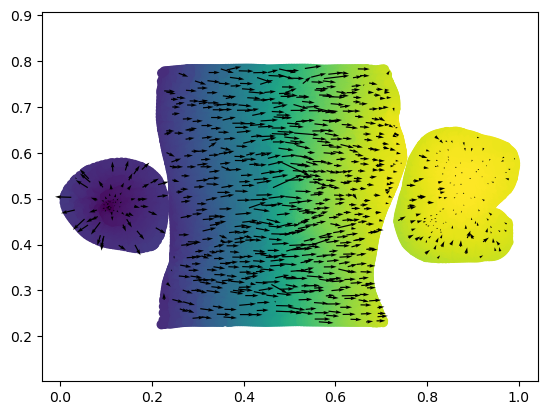

In [47]:
plt.scatter(*mesh.texture_vertices.T, c=scalar_field[mesh.get_vertex_to_texture_vertex_indices()])

sk = 25
plt.quiver(mesh.texture_vertices[::sk, 0], mesh.texture_vertices[::sk, 1],
           scalar_gradient_projected[::sk, 0], scalar_gradient_projected[::sk, 1])

plt.axis("equal")

### Projection onto surface normal


In [340]:
#| export

def get_normal_projector(vertices=None, faces=None, normals=None):
    """
    Get projection matrix that removes component normal to surface
    
    Mathematicall, 1-n.n^T where n is the unit surface normal.
    Defined per vertex. 
    
    Parameters
    ----------
    vertices : np.array of shape (#vertices, dim) or None
        vertices. If None, must supply normals
    faces : np.array of shape (#faces, 3) or None
        Triangular faces. If None, must supply normals
    normals : None or np.array of shape (#vertices, dim)
        If None, recompute normals from vertices and faces
    Returns
    -------
    np.array of shape (#vertices, dim, dim)
        Projector

    """
    if normals is None:
        normals = igl.per_vertex_normals(vertices, faces)
        normals = (normals.T/np.linalg.norm(normals, axis=-1)).T
    return np.eye(normals.shape[1])-np.einsum('vi,vj->vij', normals, normals)

def separate_tangential_normal(field, vertices=None, faces=None, normals=None):
    """
    Separate tangential and normal component of field defined at vertices.
    
    Vector and rank-2 tensor fields are supported. For a rank-2 tensor,
    normal-tangential cross components are discarded.
    
    Parameters
    ----------
    field : np.array of shape (#vertices, dim) or (#vertices, dim, dim)
        Vector or rank-2 tensor field defined at vertices
    vertices : np.array of shape (#vertices, dim) or None
        vertices. If None, must supply normals
    faces : np.array of shape (#faces, 3) or None
        Triangular faces. If None, must supply normals
    normals : None or np.array of shape (#vertices, dim)
        If None, recompute normals from vertices and faces
    Returns
    -------
    tangential_component : np.array of shape (#vertices, dim) or (#vertices, dim, dim)
    normal_component : np.array of shape (#vertices, dim) or (#vertices, dim, dim)

    """
    P = get_normal_projector(vertices, faces, normals)
    P_orth = np.eye(P.shape[-1]) - P 
    n_components = len(field.shape) - 1
    assert n_components in [1, 2], "Must be vector or rank-2 tensor field"
    if n_components == 1:
        tangential_component = np.einsum('vij,vj->vi', P, field)
        normal_component = field - tangential_component
    elif n_components == 2:
        tangential_component = np.einsum('vij,vjk,vkl->vil', P, field, P)
        normal_component = np.einsum('vij,vjk,vkl->vil', P_orth, field, P_orth)
    return tangential_component, normal_component

In [341]:
P = get_normal_projector(mesh.vertices, mesh.tris)

In [342]:
tangential, normal = separate_tangential_normal(vector_field, normals=mesh.normals)

In [343]:
np.einsum('vi,vi->v', tangential, mesh.normals), np.einsum('vi,vi->v', normal, mesh.normals)

(array([ 0., -0.,  0., ..., -0., -0., -0.]),
 array([-0.06718179, -0.04377946, -0.05600313, ...,  2.12349016,
         2.13133224,  0.08242413]))

## div and rot

In [417]:
#| export

def get_div(field, vertices, faces, normals=None):
    """
    Calculate tangent-plane divergence of vector field defined on vertices of triangular mesh.

    Parameters
    ----------
    field : np.array of shape (#vertices, dim)
        vector field defined at mesh vertices
    vertices : np.array of shape (#vertices, dim)
        vertices.
    faces : np.array of shape (#faces, 3)
        Triangular faces.
    normals : np.array of shape (#vertices, dim) or None
        If None, recompute normals from vertices and faces

    Returns
    -------
    np.array of shape (#vertices,)
        Divergence of vector field.

    """
    gradient = tri_grad(field, vertices, faces)
    gradient, _ = separate_tangential_normal(gradient, vertices, faces, normals)
    gradient_symmetric = (gradient + gradient.transpose((0,2,1)))/2
    return np.trace(gradient_symmetric, axis1=1, axis2=2)

def get_rot(field, vertices, faces, normals=None):
    """
    Calculate tangent-plane rotation of vector field defined on vertices of triangular mesh.
    
    This result is a scalar, equal to (Nabla x field).normals

    Parameters
    ----------
    field : np.array of shape (#vertices, dim)
        vector field defined at mesh vertices
    vertices : np.array of shape (#vertices, dim)
        vertices.
    faces : np.array of shape (#faces, 3)
        Triangular faces.
    normals : np.array of shape (#vertices, dim) or None
        If None, recompute normals from vertices and faces

    Returns
    -------
    np.array of shape (#vertices,)
        Curl of vector field. 

    """
    if normals is None:
        normals = igl.per_vertex_normals(vertices, faces)
        normals = (normals.T/np.linalg.norm(normals, axis=-1)).T

    gradient = tri_grad(field, vertices, faces)
    gradient, _ = separate_tangential_normal(gradient, vertices, faces, normals)
    gradient_antisymmetric = (gradient - gradient.transpose((0,2,1)))/2

    curl = np.stack([gradient_antisymmetric[:,1,2],
                     gradient_antisymmetric[:,2,0],
                     gradient_antisymmetric[:,0,1],], axis=-1)
    
    return np.einsum('vi,vi->v', normals, curl)

def get_grad_perp(field, vertices, faces, normals=None):
    """
    Calculate the gradient of scalar field, rotated by 90 deg around surface normal.
    
    As occurs e.g. when calculating vector field from stream function.
    
    Parameters
    ----------
    field : np.array of shape (#vertices,)
        Scalar field defined at mesh vertices
    vertices : np.array of shape (#vertices, dim)
        vertices.
    faces : np.array of shape (#faces, 3)
        Triangular faces.
    normals : np.array of shape (#vertices, dim) or None
        If None, recompute normals from vertices and faces.
        sign of normals determines sense of rotation.

    Returns
    -------
    np.array of shape (#vertices, dim)
        90-degree rotated gradient of scalar field. 

    """
    if normals is None:
        normals = igl.per_vertex_normals(vertices, faces)
        normals = (normals.T/np.linalg.norm(normals, axis=-1)).T
    assert len(field.shape) == 1, "Must be scalar field"
    gradient = tri_grad(field, vertices, faces)
    gradient, _ = separate_tangential_normal(gradient, vertices, faces, normals)
    # construct 90 deg rotation
    quaternion = np.pad(np.sin(np.pi/4)*normals, ((0,0), (1,0)), constant_values=np.cos(np.pi/4))
    quaternion = (quaternion.T / np.linalg.norm(quaternion, axis=1))
    R = tcrot.quaternion_to_rot_max(quaternion).T
    return np.einsum('vij,vj->vi', R, gradient)

In [418]:
get_div(vector_field, mesh.vertices, mesh.tris)

array([-0.00132147, -0.00133631, -0.00139445, ..., -0.01190545,
       -0.01149585, -0.00547986])

In [419]:
get_rot(vector_field, mesh.vertices, mesh.tris)

array([-0.00019284, -0.00021695, -0.00021081, ..., -0.00062418,
       -0.00052652,  0.00221077])

In [420]:
field, vertices, faces = (vector_field, mesh.vertices, mesh.tris)
normals = None

In [421]:
if normals is None:
    normals = igl.per_vertex_normals(vertices, faces)
    normals = (normals.T/np.linalg.norm(normals, axis=-1)).T
    
gradient = tri_grad(field, vertices, faces)
gradient, _ = separate_tangential_normal(gradient, vertices, faces, normals)
gradient_antisymmetric = (gradient - gradient.transpose((0,2,1)))/2

curl = np.stack([gradient_antisymmetric[:,1,2],
                 gradient_antisymmetric[:,2,0],
                 gradient_antisymmetric[:,0,1],], axis=-1)

In [422]:
separate_tangential_normal(curl, vertices, faces, normals)

(array([[-0.,  0., -0.],
        [-0.,  0., -0.],
        [-0.,  0., -0.],
        ...,
        [ 0.,  0., -0.],
        [ 0.,  0., -0.],
        [ 0., -0., -0.]]),
 array([[ 0.0000478 ,  0.00011754,  0.00014521],
        [ 0.00005575,  0.00013606,  0.00015952],
        [ 0.00005253,  0.0001479 ,  0.00014075],
        ...,
        [-0.00039696, -0.00047615, -0.00007285],
        [-0.00034797, -0.0003917 , -0.000052  ],
        [ 0.00158867, -0.0003214 ,  0.00150344]]))

In [424]:
get_grad_perp(scalar_field, mesh.vertices, mesh.tris)

array([[-0.00017377, -0.0005341 ,  0.00048953],
       [-0.00009454, -0.00050926,  0.00046743],
       [ 0.00000551, -0.00045902,  0.00048029],
       ...,
       [ 0.00050851, -0.00026402, -0.00104531],
       [ 0.00051104, -0.00031591, -0.00104012],
       [ 0.00138572, -0.00019865, -0.00150675]])